In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import folium
from folium import Choropleth
import geopandas as gpd

# Screenshot the map with Selenium and display it as image
from selenium import webdriver
from IPython.display import display, Image
from time import sleep
# Markdown looks better than print
from IPython.display import Markdown as md

sns.set_style("whitegrid")
sns.set_context('poster')
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

In [ ]:
#Parameters
country="LU"
debug=True

# Setup

To generate this report, you need to complete your environment with [Firefox](https://www.mozilla.org/en-US/firefox/new/), [Geckodriver](https://github.com/mozilla/geckodriver/releases) and Selenium `conda install selenium`.

In [ ]:
# Data

In [ ]:
## Migration Data - Raw

In [ ]:
from eurostatapiclient import EurostatAPIClient

#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [ ]:
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 
                   'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE':'Estonia', 
                   'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 
                   'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT': 'Malta', 
                   'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'UK':'United_Kingdom'}

In [ ]:
df = []
for sex in ['M', 'F']:
    for age in ['TOTAL', 'Y_GE65', 'Y_LT15']:
        par_df = {
            'agedef': 'REACH',
            'sex': sex,
            'unit': 'NR',
            'geo': list(countries_names.keys()),
            'c_birth': list(countries_names.keys()),
            'age': age}

        df.append(client.get_dataset('migr_imm3ctb', params=par_df).to_dataframe())

In [ ]:
df = pd.concat(df, axis=0)
df.reset_index(drop=True, inplace=True)
df.rename(columns={"c_birth": "cbirth"}, inplace=True)
df['age'] = df['age'].map({'TOTAL': 'TOTAL', 'Y_LT15': 'LT15', 'Y_GE65': 'GE65'})

In [ ]:
def table_to_latex(df):
    latex = rf"""\begin{{table}}[]
    \begin{{tabular}}{{| r | {' r |' * len(df.columns)}}} \hline"""
    latex += rf"""
        & {' & '.join([str(col) for col in list(df.columns)])} \\ \hline \hline"""
    for i, row in df.sample(6).iterrows():
        latex += rf"""
        {str(i)} & {' & '.join([str(col) for col in row])} \\\hline """
    latex += rf"""\hline
    \end{{tabular}} 
\end{{table}}
"""
    return latex

In [ ]:
if debug:
    print(df.sample(6))

       values    age agedef cbirth unit sex geo  time
5853     40.0  TOTAL  REACH     PT   NR   M  CZ  2017
18516    71.0  TOTAL  REACH     BE   NR   F  HU  2008
26190     0.0   GE65  REACH     CY   NR   F  HR  2014
22567    20.0  TOTAL  REACH     LT   NR   F  RO  2015
25710     1.0   GE65  REACH     AT   NR   F  SK  2014
16082     NaN   LT15  REACH     LU   NR   M  EE  2010


In [ ]:
## Migration Data - Processed

In [ ]:
### Ballast Drop

In [ ]:
df.drop('agedef', axis=1, inplace=True)
df.drop('unit', axis=1, inplace=True)

In [ ]:
if debug:
    print(df[(df['geo']==country) & (df['time']=='2018') & (df['cbirth']=='BE')])

       values    age cbirth sex geo  time
430     639.0  TOTAL     BE   M  LU  2018
7714     27.0   GE65     BE   M  LU  2018
13090    76.0   LT15     BE   M  LU  2018
18574   507.0  TOTAL     BE   F  LU  2018
25858    25.0   GE65     BE   F  LU  2018
31234    98.0   LT15     BE   F  LU  2018


In [ ]:
### NaN Handling

In [ ]:
df = df.pivot(
    index=['cbirth', 'geo', 'time', 'sex'],
    columns=['age'],
    values='values')

In [ ]:
if debug:
    print(df.sample(6))

age                  GE65   LT15   TOTAL
cbirth geo time sex                     
CZ     FR  2011 F     NaN    NaN     NaN
SE     LU  2011 M     NaN    NaN    49.0
MT     NL  2010 F     0.0    1.0    10.0
FI     EE  2017 F    22.0  107.0   423.0
BE     FR  2018 M     NaN    NaN  3997.0
FR     HU  2014 F     5.0   12.0   170.0


In [ ]:
# Replaced NaN by zero (0)

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
if debug:
    print(df.sample(6))

age                  GE65  LT15   TOTAL
cbirth geo time sex                    
NL     IE  2008 F     0.0   0.0   216.0
MT     LV  2014 M     0.0   0.0     1.0
IT     HR  2014 F     7.0  14.0    89.0
PL     LV  2013 M     0.0   0.0     0.0
IT     NL  2008 M     0.0   0.0  1409.0
HR     BG  2017 F     0.0   0.0     3.0


In [ ]:
### Age Classification

In [ ]:
#children: immigrants listed younger than 15
#elderly: immigrants listed 65 and older
#working-population: Total number of immigrants minus children and elderly

In [ ]:
df['children'] = df['LT15']
df['working-age'] = df['TOTAL'] - df['LT15'] - df['GE65']
df['elderly'] = df['GE65']

df.drop(['TOTAL', 'GE65', 'LT15'], axis=1,inplace=True)

In [ ]:
if debug:
    print(df.sample(6))

age                  children  working-age  elderly
cbirth geo time sex                                
PL     BE  2013 F       433.0       2573.0     30.0
MT     NL  2011 F         1.0         10.0      0.0
CZ     BG  2012 M         0.0         18.0      0.0
PT     BE  2019 F       181.0        749.0     20.0
ES     IE  2019 M         0.0          0.0      0.0
EE     RO  2014 M         0.0          2.0      0.0


In [ ]:
df = df.reset_index().melt(
    id_vars=['cbirth', 'geo', 'time', 'sex'],
    value_vars=['children', 'elderly', 'working-age'])

In [ ]:
if debug:
    print(df.sample(6))

      cbirth geo  time sex          age  value
34852     FI  AT  2010   F  working-age    0.0
38498     LT  SK  2009   F  working-age    0.0
32817     DK  CZ  2012   M  working-age   14.0
11061     NL  SK  2018   M     children   17.0
30933     BG  IT  2018   M  working-age  650.0
727       BE  FR  2011   M     children    0.0


In [ ]:
### Name Mapping

In [ ]:
df.rename(columns={'geo': 'country of arrival', 'cbirth': 'country of birth', 'value': 'immigrants', 'time': 'year'}, inplace=True)
df['year'] = df['year'].astype('int')
df['country of birth'] = df['country of birth'].map(countries_names)
df['country of arrival'] = df['country of arrival'].map(countries_names)
country = countries_names[country]

In [ ]:
if debug:
    print(df.sample(6))

      country of birth country of arrival  year sex          age  immigrants
1852            Cyprus            Ireland  2010   F     children         0.0
9066        Luxembourg            Czechia  2017   F     children         0.0
2248           Czechia            Estonia  2016   F     children         0.0
8473         Lithuania            Belgium  2008   M     children         0.0
30263          Belgium              Spain  2019   M  working-age      1457.0
44046   United Kingdom            Croatia  2011   F  working-age        29.0


In [ ]:
## Geospatial Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    dir = os.path.join('gdrive', 'MyDrive', 'Eurostat', '01 - Intro to Python for Data Science')
else:
    dir = '.'
    
data_dir = os.path.join(dir, 'data')
os.makedirs(data_dir, exist_ok=True)
data_dir
if debug:
    print(data_dir)

.\data


In [ ]:
#Place the content of [NUTS_RG_10M_2021_4326_LEVL_0.shp](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts) into your data_dir

In [ ]:
nuts0 = gpd.read_file(os.path.join(data_dir, 'NUTS_RG_10M_2021_4326_LEVL_0.shp'))
nuts0.dropna(axis=0, subset=['NUTS_ID'], inplace=True)
nuts0.set_index('NUTS_ID', inplace=True, drop=True)

In [ ]:
if debug:
    print(nuts0.sample(6))

         LEVL_CODE CNTR_CODE      NAME_LATN      NUTS_NAME  MOUNT_TYPE  \
NUTS_ID                                                                  
PT               0        PT       Portugal       Portugal           0   
SE               0        SE        Sverige        Sverige           0   
LU               0        LU     Luxembourg     Luxembourg           0   
LI               0        LI  Liechtenstein  Liechtenstein           0   
LV               0        LV        Latvija        Latvija           0   
IS               0        IS         Ísland         Ísland           0   

        URBN_TYPE  COAST_TYPE FID  \
NUTS_ID                             
PT           None           0  PT   
SE           None           0  SE   
LU           None           0  LU   
LI           None           0  LI   
LV           None           0  LV   
IS           None           0  IS   

                                                  geometry  
NUTS_ID                                          

In [ ]:
%%latex
\newpage

<IPython.core.display.Latex object>

In [ ]:
# Visualizations

# Immigrants by gender and age

In [ ]:
if (len(df[df['country of arrival'] == country])):
    _df = df[df['country of arrival'] == country].pivot_table(
        columns=['age'],
        index=['year', 'sex'],
        values='immigrants',
        aggfunc=np.sum)

    _df['<65 cumul'] = _df['children'] + _df['working-age']
    _df['total'] = _df['children'] + _df['working-age'] + _df['elderly']
    _df.reset_index(inplace=True)
    
else:
    print(f'No immigrants have been registered for {country}.')

In [ ]:
if debug and (len(df[df['country of arrival'] == country])):
    print(_df)

age  year sex  children  elderly  working-age  <65 cumul   total
0    2008   F       0.0      0.0       6108.0     6108.0  6108.0
1    2008   M       0.0      0.0       7614.0     7614.0  7614.0
2    2009   F       0.0      0.0       5459.0     5459.0  5459.0
3    2009   M       0.0      0.0       6518.0     6518.0  6518.0
4    2010   F       0.0      0.0       5558.0     5558.0  5558.0
5    2010   M       0.0      0.0       6876.0     6876.0  6876.0
6    2011   F       0.0      0.0       6428.0     6428.0  6428.0
7    2011   M       0.0      0.0       8077.0     8077.0  8077.0
8    2012   F       0.0      0.0       6707.0     6707.0  6707.0
9    2012   M       0.0      0.0       8266.0     8266.0  8266.0
10   2013   F    1317.0    265.0       5257.0     6574.0  6839.0
11   2013   M    1346.0    321.0       6453.0     7799.0  8120.0
12   2014   F    1147.0    320.0       5739.0     6886.0  7206.0
13   2014   M    1206.0    388.0       6995.0     8201.0  8589.0
14   2015   F    1136.0  

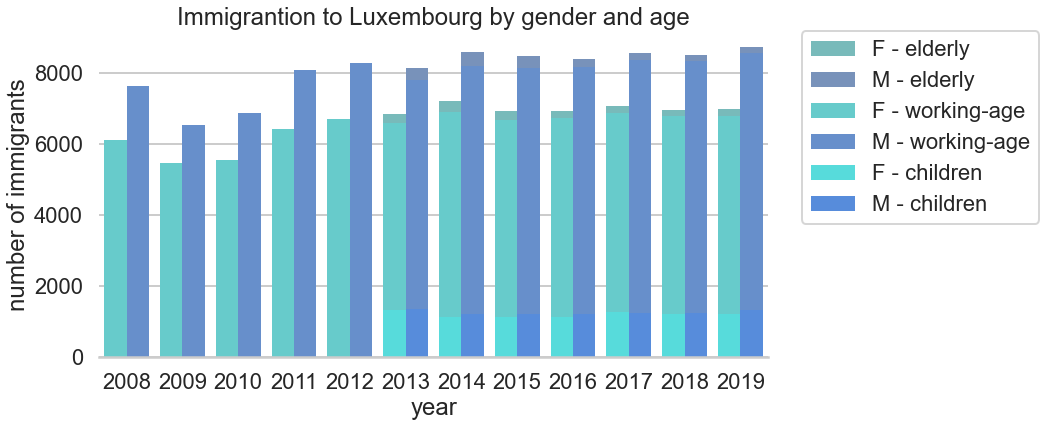

In [ ]:
if (len(df[df['country of arrival'] == country])):
    fig, ax = plt.subplots(figsize=(12, 6))

    __df = _df.copy()
    __df['sex'] = __df['sex'].map({'M': 'M - elderly', 'F': 'F - elderly'})
    sns.barplot(data=__df,
                x='year',
                y='total',
                hue='sex',
                saturation=0.5, 
                linewidth=0)

    __df = _df.copy()
    __df['sex'] = __df['sex'].map({'M': 'M - working-age', 'F': 'F - working-age'})
    sns.barplot(data=__df,
                x='year',
                y='<65 cumul',
                hue='sex',
                saturation=0.75,
                linewidth=0)

    __df = _df.copy()
    __df['sex'] = __df['sex'].map({'M': 'M - children', 'F': 'F - children'})
    sns.barplot(data=__df,
                x='year',
                y='children',
                hue='sex',
                saturation=1,
                linewidth=0)
    sns.despine(left=True, top=True, right=True)

    plt.title(f"Immigrantion to {country} by gender and age")
    ax.set_ylabel('number of immigrants')
    ax.set_xlabel('year')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

# Immigrants by country of birth

In [ ]:
if (len(df[df['country of arrival'] == country])):
    _df = df[df['country of arrival'] == country].pivot_table(
        index=['country of birth'],
        values='immigrants',
        aggfunc=np.sum)

    _df.index = _df.index.map({v: k for k, v in zip(countries_names.keys(), countries_names.values())})
    
else:
    print(f'No immigrants have been registered for {country}.')

In [ ]:
if debug and len(df[df['country of arrival'] == country]):
    print(_df.sample(10))

                  immigrants
country of birth            
ES                    5561.0
BG                    1853.0
CY                     159.0
IE                    1392.0
SE                    1384.0
DK                    1175.0
HR                     940.0
PL                    5289.0
RO                    6253.0
SK                     874.0


In [ ]:
if (len(df[df['country of arrival'] == country])):
    m = folium.Map(location=[49.63321762577624, 6.169436798146017],
               tiles='CartoDB positron',
               zoom_start=4)

    Choropleth(geo_data=nuts0.__geo_interface__, 
               key_on="feature.id", 
               data=_df['immigrants'],
               fill_color='YlGnBu', 
               legend_name=f"Immigrants to Luxembourg by country of birth (2008-2019)"
              ).add_to(m)

    m

In [ ]:
# Selenium's magic

In [ ]:
if (len(df[df['country of arrival'] == country])):
    filename = f'map_{country}.html'
    m.save(os.path.join(dir, filename))
    driver = webdriver.Firefox(executable_path=os.path.join(data_dir, 'geckodriver.exe'))
    mapUrl = f"file://{os.getcwd()}/{filename}"
    driver.get(mapUrl)
    sleep(3)
    driver.save_screenshot(os.path.join(data_dir, filename.replace('.html', '.png')))
    driver.quit()

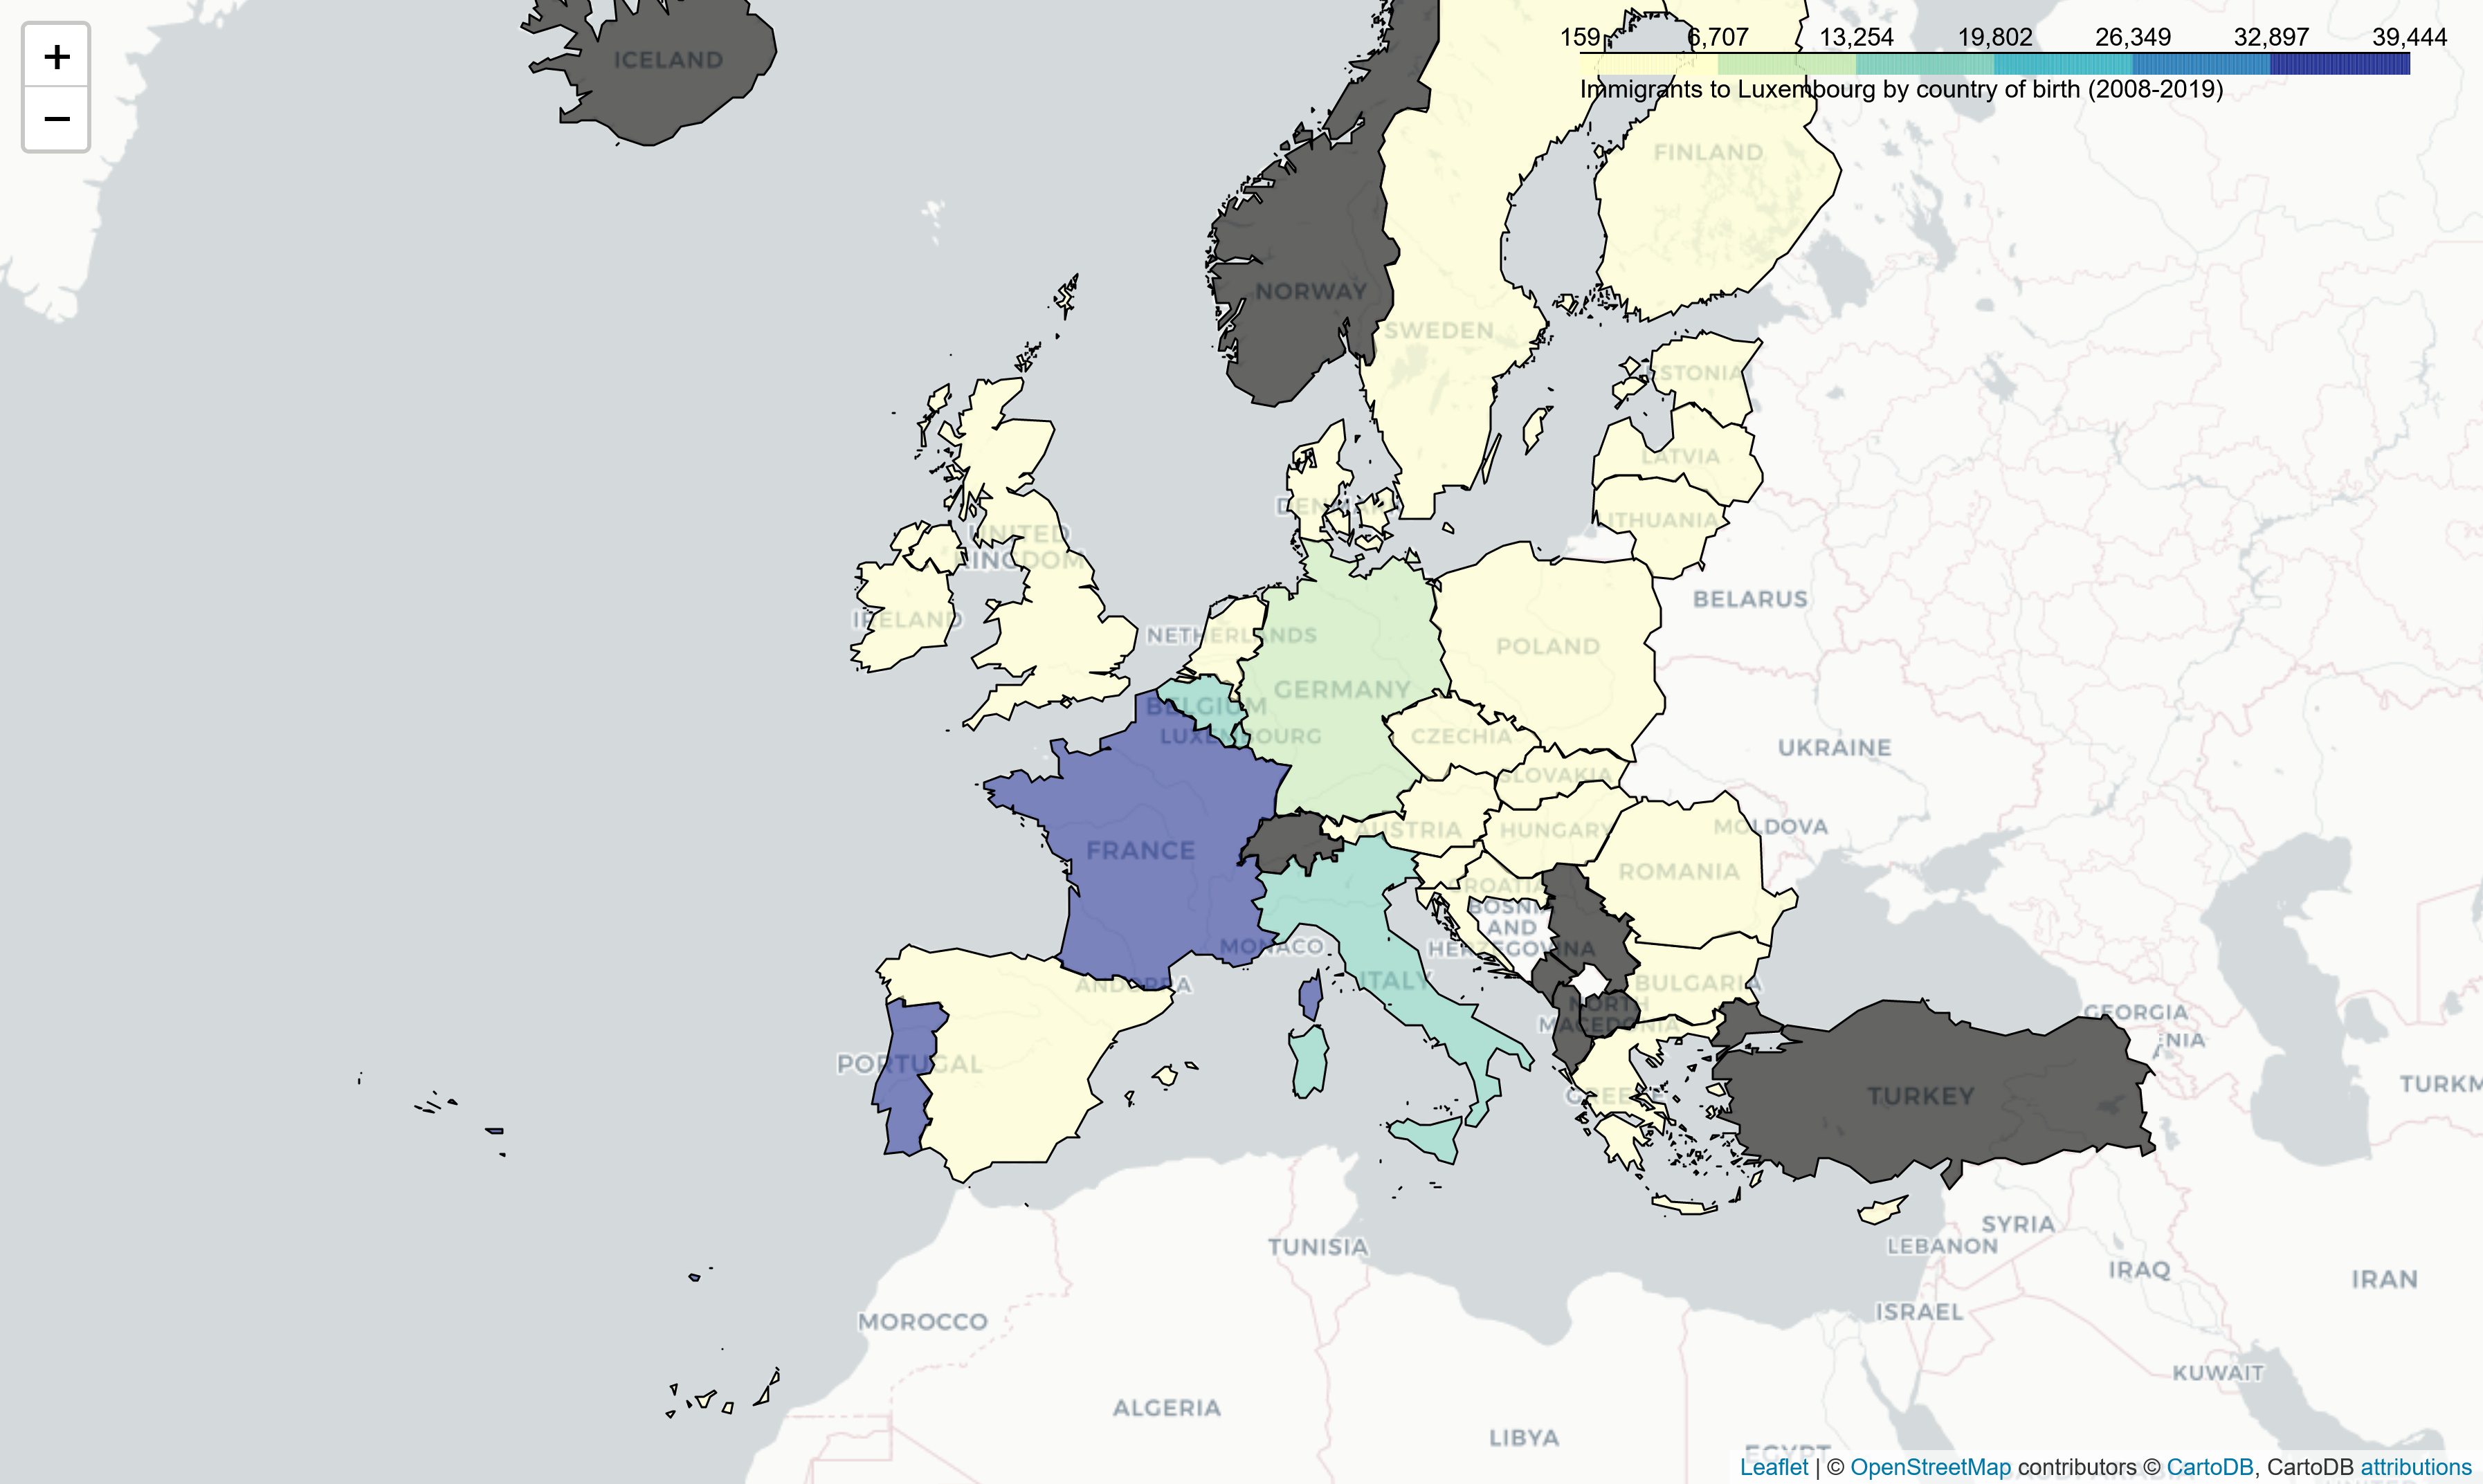

In [ ]:
try:
    display(Image(filename=os.path.join(data_dir, filename.replace('.html', '.png'))))
except:
    pass

In [ ]:
if len(df[df['country of arrival'] == country]):
    dominant_country_of_birth = _df.sort_values(by='immigrants', ascending=False).iloc[0].name
    sentence = f"Most immigrants to {country} were born in {countries_names[dominant_country_of_birth]}!"

md(f"{sentence if len(df[df['country of arrival'] == country]) else ''}")

Most immigrants to Luxembourg were born in France!

In [ ]:
%%latex
\nopagebreak 

<IPython.core.display.Latex object>

# Annual immigration rate by origin

In [ ]:
if (len(df[df['country of arrival'] == country])):
    _df = df[df['country of arrival'] == country].pivot_table(
        values='immigrants',
        columns='year',
        index='country of birth',
        aggfunc=np.sum)

In [ ]:
#md(f"The following tabe holds the annual number of immigrants to {country}, by country of birth:")

In [ ]:
def table_to_latex(df):
    latex = rf"""\scalebox{{0.9}}{{\rotatebox{{90}}{{
    \begin{{tabular}}{{| r | {' r |' * len(df.columns)}}} \hline"""
    latex += rf"""
        & {' & '.join([str(col) for col in list(df.columns)])} \\ \hline \hline"""
    for i, row in df.iterrows():
        latex += rf"""
        {str(i)} & {' & '.join([str(col) for col in row])} \\\hline """
    latex += rf"""\hline
    \end{{tabular}} 
}} }}
"""
    return latex

In [ ]:
md(f"{table_to_latex(_df) if len(df[df['country of arrival'] == country]) else f'No immigrants have been registered for {country}.'}")

\scalebox{0.9}{\rotatebox{90}{
    \begin{tabular}{| r |  r | r | r | r | r | r | r | r | r | r | r | r |} \hline
        & 2008 & 2009 & 2010 & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 \\ \hline \hline
        Austria & 58.0 & 65.0 & 66.0 & 55.0 & 67.0 & 52.0 & 95.0 & 76.0 & 77.0 & 74.0 & 66.0 & 82.0 \\\hline 
        Belgium & 952.0 & 955.0 & 1059.0 & 1071.0 & 1216.0 & 1384.0 & 1490.0 & 1424.0 & 1203.0 & 1245.0 & 1146.0 & 1180.0 \\\hline 
        Bulgaria & 162.0 & 108.0 & 101.0 & 144.0 & 122.0 & 98.0 & 172.0 & 179.0 & 211.0 & 189.0 & 187.0 & 180.0 \\\hline 
        Croatia & 9.0 & 9.0 & 32.0 & 34.0 & 68.0 & 72.0 & 121.0 & 98.0 & 124.0 & 107.0 & 123.0 & 143.0 \\\hline 
        Cyprus & 3.0 & 6.0 & 8.0 & 14.0 & 11.0 & 17.0 & 22.0 & 9.0 & 19.0 & 17.0 & 14.0 & 19.0 \\\hline 
        Czechia & 114.0 & 95.0 & 92.0 & 108.0 & 80.0 & 62.0 & 83.0 & 101.0 & 77.0 & 83.0 & 79.0 & 76.0 \\\hline 
        Denmark & 125.0 & 116.0 & 87.0 & 95.0 & 107.0 & 131.0 & 92.0 & 84.0 & 81.0 & 85.0 & 91.0 & 81.0 \\\hline 
        Estonia & 69.0 & 34.0 & 56.0 & 49.0 & 56.0 & 50.0 & 42.0 & 39.0 & 38.0 & 54.0 & 43.0 & 42.0 \\\hline 
        Finland & 80.0 & 59.0 & 76.0 & 115.0 & 60.0 & 73.0 & 88.0 & 107.0 & 98.0 & 84.0 & 103.0 & 95.0 \\\hline 
        France & 2919.0 & 2501.0 & 2678.0 & 2969.0 & 3207.0 & 3179.0 & 3583.0 & 3723.0 & 3616.0 & 3787.0 & 3598.0 & 3684.0 \\\hline 
        Germany & 1120.0 & 957.0 & 972.0 & 1134.0 & 968.0 & 1023.0 & 1020.0 & 1008.0 & 937.0 & 1002.0 & 995.0 & 975.0 \\\hline 
        Greece & 87.0 & 88.0 & 119.0 & 174.0 & 249.0 & 250.0 & 282.0 & 322.0 & 409.0 & 490.0 & 371.0 & 407.0 \\\hline 
        Hungary & 119.0 & 113.0 & 132.0 & 169.0 & 144.0 & 216.0 & 218.0 & 171.0 & 167.0 & 231.0 & 178.0 & 142.0 \\\hline 
        Ireland & 94.0 & 74.0 & 109.0 & 137.0 & 90.0 & 85.0 & 114.0 & 123.0 & 125.0 & 150.0 & 141.0 & 150.0 \\\hline 
        Italy & 662.0 & 534.0 & 621.0 & 796.0 & 955.0 & 1075.0 & 1410.0 & 1403.0 & 1559.0 & 1541.0 & 1570.0 & 1584.0 \\\hline 
        Latvia & 50.0 & 50.0 & 57.0 & 79.0 & 56.0 & 68.0 & 79.0 & 63.0 & 64.0 & 58.0 & 53.0 & 82.0 \\\hline 
        Lithuania & 88.0 & 66.0 & 56.0 & 73.0 & 64.0 & 63.0 & 83.0 & 116.0 & 104.0 & 79.0 & 96.0 & 134.0 \\\hline 
        Luxembourg & 1100.0 & 1251.0 & 1260.0 & 1242.0 & 1272.0 & 1480.0 & 1331.0 & 1152.0 & 1336.0 & 1197.0 & 1260.0 & 1337.0 \\\hline 
        Malta & 27.0 & 29.0 & 34.0 & 20.0 & 21.0 & 19.0 & 26.0 & 25.0 & 20.0 & 18.0 & 16.0 & 18.0 \\\hline 
        Netherlands & 261.0 & 180.0 & 169.0 & 183.0 & 184.0 & 213.0 & 227.0 & 206.0 & 186.0 & 227.0 & 180.0 & 176.0 \\\hline 
        Poland & 500.0 & 387.0 & 382.0 & 423.0 & 408.0 & 375.0 & 511.0 & 505.0 & 427.0 & 436.0 & 501.0 & 434.0 \\\hline 
        Portugal & 3854.0 & 3204.0 & 3059.0 & 3990.0 & 4106.0 & 3443.0 & 2785.0 & 2576.0 & 2551.0 & 2498.0 & 2580.0 & 2585.0 \\\hline 
        Romania & 306.0 & 256.0 & 331.0 & 460.0 & 423.0 & 391.0 & 728.0 & 672.0 & 595.0 & 652.0 & 737.0 & 702.0 \\\hline 
        Slovakia & 84.0 & 61.0 & 75.0 & 63.0 & 76.0 & 62.0 & 76.0 & 81.0 & 80.0 & 66.0 & 93.0 & 57.0 \\\hline 
        Slovenia & 50.0 & 47.0 & 44.0 & 49.0 & 36.0 & 57.0 & 49.0 & 58.0 & 57.0 & 53.0 & 51.0 & 37.0 \\\hline 
        Spain & 212.0 & 210.0 & 270.0 & 383.0 & 424.0 & 502.0 & 507.0 & 578.0 & 650.0 & 618.0 & 572.0 & 635.0 \\\hline 
        Sweden & 176.0 & 102.0 & 119.0 & 88.0 & 113.0 & 117.0 & 148.0 & 138.0 & 105.0 & 84.0 & 95.0 & 99.0 \\\hline 
        United Kingdom & 441.0 & 420.0 & 370.0 & 388.0 & 390.0 & 402.0 & 413.0 & 370.0 & 398.0 & 507.0 & 522.0 & 569.0 \\\hline \hline
    \end{tabular} 
} }


In [ ]:
if debug and len(df[df['country of arrival'] == country]):
    print(_df)

year                2008    2009    2010    2011    2012    2013    2014  \
country of birth                                                           
Austria             58.0    65.0    66.0    55.0    67.0    52.0    95.0   
Belgium            952.0   955.0  1059.0  1071.0  1216.0  1384.0  1490.0   
Bulgaria           162.0   108.0   101.0   144.0   122.0    98.0   172.0   
Croatia              9.0     9.0    32.0    34.0    68.0    72.0   121.0   
Cyprus               3.0     6.0     8.0    14.0    11.0    17.0    22.0   
Czechia            114.0    95.0    92.0   108.0    80.0    62.0    83.0   
Denmark            125.0   116.0    87.0    95.0   107.0   131.0    92.0   
Estonia             69.0    34.0    56.0    49.0    56.0    50.0    42.0   
Finland             80.0    59.0    76.0   115.0    60.0    73.0    88.0   
France            2919.0  2501.0  2678.0  2969.0  3207.0  3179.0  3583.0   
Germany           1120.0   957.0   972.0  1134.0   968.0  1023.0  1020.0   
Greece      